# Model Selection and Implementation - Wheat Pricing Data
## Time Series and Machine Learning Final Project Code
## Will Bartlett and David Whitmer

In [172]:
#import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
import itertools
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [3]:
#Import Dataset
df = pd.read_csv('../Final Data/Final_Data.csv')
#drop temperature data; low correlation to target
df = df.drop(columns = 'avg_temp')

## 1 Time Series Model Tests
### 1.1 AR Model

In [5]:
#Find optimal lag to test
best_model = ar_select_order(df['wheat_price'], maxlag=25, ic='aic', old_names=False)
print(f"Optimal lag order selected for Monthly return : {best_model.ar_lags}")

Optimal lag order selected for Monthly return : [1, 2, 3, 4, 5, 6, 7, 8]


In [6]:
#AR(1) Model
ar_1 = AutoReg(df['wheat_price'], lags = 1).fit()
ar_1_aic = ar_1.aic
print('AR(1) Results: \n',ar_1.summary())

AR(1) Results: 
                             AutoReg Model Results                             
Dep. Variable:            wheat_price   No. Observations:                  421
Model:                     AutoReg(1)   Log Likelihood                -390.448
Method:               Conditional MLE   S.D. of innovations              0.613
Date:                Mon, 28 Apr 2025   AIC                            786.896
Time:                        18:11:49   BIC                            799.017
Sample:                             1   HQIC                           791.687
                                  421                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2741      0.083      3.308      0.001       0.112       0.436
wheat_price.L1     0.9438      0.016     58.648      0.000       0.912       0.975
                   

In [7]:
#AR(2) Model
ar_2 = AutoReg(df['wheat_price'], lags = 2).fit()
ar_2_aic = ar_2.aic
print('\nAR(2) Results: \n',ar_2.summary())


AR(2) Results: 
                             AutoReg Model Results                             
Dep. Variable:            wheat_price   No. Observations:                  421
Model:                     AutoReg(2)   Log Likelihood                -374.137
Method:               Conditional MLE   S.D. of innovations              0.591
Date:                Mon, 28 Apr 2025   AIC                            756.273
Time:                        18:11:49   BIC                            772.425
Sample:                             2   HQIC                           762.658
                                  421                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2043      0.081      2.526      0.012       0.046       0.363
wheat_price.L1     0.6891      0.047     14.650      0.000       0.597       0.781
wheat_price.L2    

### 1.2 ARIMA Model

In [9]:
#Find best params for ARIMA model
p = range(0, 3)  # AR order
d = range(0, 2)  # Differencing
q = range(0, 3)  # MA order
pdq = list(itertools.product(p, d, q))

#use aic for best model, set up saves
best_aic = float('inf')
best_pdq = None

for param in pdq:
    try:
        model = ARIMA(df['wheat_price'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue

best_arima_aic = best_aic

print(f"Best ARIMA order based on AIC: {best_pdq}")

Best ARIMA order based on AIC: (0, 1, 1)


In [10]:
#Test best model ARIMA(0,1,1)
arima_011 = ARIMA(df['wheat_price'], order=best_pdq).fit()
print('ARIMA(0,1,1) Results: \n',arima_011.summary())

ARIMA(0,1,1) Results: 
                                SARIMAX Results                                
Dep. Variable:            wheat_price   No. Observations:                  421
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -374.330
Date:                Mon, 28 Apr 2025   AIC                            752.660
Time:                        18:11:50   BIC                            760.741
Sample:                             0   HQIC                           755.854
                                - 421                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3533      0.027    -13.308      0.000      -0.405      -0.301
sigma2         0.3480      0.008     44.367      0.000       0.333       0.363
Ljung-Box (L1) (Q):         

### 1.4 ARIMAX Model

In [12]:
#Save exogenous data separately
exog_data = df.copy().drop(columns = ['wheat_price','date'])

#standardize exogenous features
exog_data = (exog_data - exog_data.mean()) / exog_data.std()

In [13]:
#Find best params for ARIMAX model
p = range(0, 3)  #AR order
d = range(0, 2)  #differencing options
q = range(0, 3)  #MA order
pdq = list(itertools.product(p, d, q))

#find best model params by aic
best_arimax_aic = float('inf')
best_arimax_params = None
for param in pdq:
    try:
        model = SARIMAX(df['wheat_price'], 
                        exog=exog_data,
                        order=param, 
                        seasonal_order=(0, 0, 0, 0))  #don't add seasonality
        results = model.fit(disp=False)
        if results.aic < best_arimax_aic:
            best_arimax_aic = results.aic
            best_arimax_params = param
    except:
        continue

print(f"Best ARIMAX model order based on AIC: {best_arimax_params}; AIC = {best_arimax_aic}")

Best ARIMAX model order based on AIC: (2, 1, 1); AIC = 727.964382296861


In [14]:
#Test ARIMAX(2,1,1)
arimax_211 = SARIMAX(df['wheat_price'], 
                     exog=exog_data,
                     order=best_arimax_params, 
                     seasonal_order=(0, 0, 0, 0)).fit(disp=False)
print('ARIMAX(2,1,1) Results: \n',arimax_211.summary())

ARIMAX(2,1,1) Results: 
                                SARIMAX Results                                
Dep. Variable:            wheat_price   No. Observations:                  421
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -351.982
Date:                Mon, 28 Apr 2025   AIC                            727.964
Time:                        18:11:54   BIC                            776.447
Sample:                             0   HQIC                           747.127
                                - 421                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
fertilizer_idx        0.5031      0.247      2.035      0.042       0.019       0.988
drought_idx          -0.1061      0.082     -1.289      0.198      -0.268       0.055

### 1.4 SARIMAX Model

#### 1.4.1 ACF Plot For Seasonality Test

<Figure size 1200x1000 with 0 Axes>

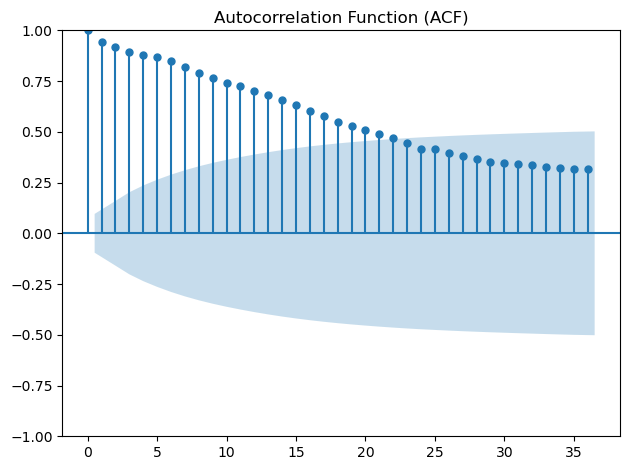

In [138]:
#Plot ACF
plt.figure(figsize=(12, 10))
plot_acf(df['wheat_price'], lags=36 ) 
plt.title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.savefig('../Visualizations/ACF.png')
plt.show()

#### 1.4.2 SARIMAX Model Implementation

In [19]:
#Find best seasonal params for SARIMAX
P = range(0, 2)  #seasonal AR order
D = range(0, 2)  #seasonal differencing
Q = range(0, 2)  #seasonal MA order
s = 12  #yearly seasonality

#Create all combinations of seasonal parameters
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

# Find best SARIMAX model with both ARIMA and seasonal components
best_sarimax_aic = float('inf')
best_seasonal_params = None

# Grid search over seasonal parameters
for seasonal_param in seasonal_pdq:
    try:
        model = SARIMAX(df['wheat_price'], 
                       exog=exog_data,
                       order=best_arimax_params, #use best arimax params
                       seasonal_order=seasonal_param,)
        
        results = model.fit(disp=False, maxiter=100)
        current_aic = results.aic
        
        if current_aic < best_sarimax_aic:
            best_sarimax_aic = current_aic
            best_seasonal_params = seasonal_param
            sarimax_results = results
    except Exception as e:
        
        continue

print(f"\nBest SARIMAX model: SARIMAX{best_arimax_params}x{best_seasonal_params}")


Best SARIMAX model: SARIMAX(2, 1, 1)x(1, 0, 1, 12)


In [20]:
#Test SARIMAX(2,1,1)x(0,0,1,12)
print(sarimax_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        wheat_price   No. Observations:                  421
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -344.232
Date:                            Mon, 28 Apr 2025   AIC                            716.463
Time:                                    18:12:27   BIC                            773.027
Sample:                                         0   HQIC                           738.820
                                            - 421                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
fertilizer_idx        0.4820      0.265      1.820      0.069      -0.037       1.001
drought_idx   

## 1.5 ARCH Model

In [22]:
#calculat percent change
df['wheat_returns'] = df['wheat_price'].pct_change() * 100
df = df.dropna()

In [23]:
#fit arch(1) model
arch_model_1 = arch_model(df['wheat_returns'], vol='ARCH', p=1, mean='AR', lags=1)
arch_result_1 = arch_model_1.fit(update_freq=0, disp='off')
print(arch_result_1.summary())
arch_1_aic = arch_result_1.aic

                           AR - ARCH Model Results                            
Dep. Variable:          wheat_returns   R-squared:                       0.073
Mean Model:                        AR   Adj. R-squared:                  0.071
Vol Model:                       ARCH   Log-Likelihood:               -1516.14
Distribution:                  Normal   AIC:                           3040.29
Method:            Maximum Likelihood   BIC:                           3056.44
                                        No. Observations:                  419
Date:                Mon, Apr 28 2025   Df Residuals:                      417
Time:                        18:12:27   Df Model:                            2
                                  Mean Model                                  
                    coef    std err          t      P>|t|     95.0% Conf. Int.
------------------------------------------------------------------------------
Const             0.1876      0.544      0.345      

## 1.6 GARCH Model

In [25]:
# Fit GARCH(1,1) model - most common specification
garch_model_11 = arch_model(df['wheat_returns'], vol='GARCH', p=1, q=1, mean='AR', lags=1)
garch_result_11 = garch_model_11.fit(update_freq=0, disp='off')
print(garch_result_11.summary())
garch_11_aic = garch_result_11.aic

                           AR - GARCH Model Results                           
Dep. Variable:          wheat_returns   R-squared:                       0.073
Mean Model:                        AR   Adj. R-squared:                  0.071
Vol Model:                      GARCH   Log-Likelihood:               -1516.14
Distribution:                  Normal   AIC:                           3042.29
Method:            Maximum Likelihood   BIC:                           3062.48
                                        No. Observations:                  419
Date:                Mon, Apr 28 2025   Df Residuals:                      417
Time:                        18:12:27   Df Model:                            2
                                  Mean Model                                 
                    coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------------------
Const             0.1876      0.542      0.346      0.7

### 1.7 Time Series Model Comparisons

### 1.7.1 AIC Comparison

In [28]:
#Compare AIC values
ts_aic = pd.DataFrame({
    'Model': ['AR(1)','AR(2)','ARIMA',"ARIMAX",'SARIMAX','ARCH','GARCH'],
    'AIC': [ar_1_aic, ar_2_aic, best_arima_aic, best_arimax_aic, best_sarimax_aic, arch_1_aic, garch_11_aic]
})
ts_aic

,Model,AIC
0,AR(1),786.896034
1,AR(2),756.273349
2,ARIMA,752.660009
3,ARIMAX,727.964382
4,SARIMAX,716.463442
5,ARCH,3040.287530
6,GARCH,3042.287529


### 1.7.2 Forecast Values 

In [30]:
#VAR model to model future exogenous values for forecasts
var_model = VAR(exog_data)
lag_order_results = var_model.select_order(maxlags=10)
optimal_lag = lag_order_results.aic #save best lags

#Fit the model with the optimal lag
var_fitted = var_model.fit(maxlags=optimal_lag)  # Use the optimal lag found

#Forecast future exog values
future_exog = var_fitted.forecast(y=exog_data.values[-optimal_lag:], steps=6)
future_exog = pd.DataFrame(future_exog, columns=exog_data.columns)

In [31]:
# Use each model to forecast the next 6 months of wheat pricing
ar_1_forecast = ar_1.predict(start=len(df), end=len(df) +5) #ar(1)
#ar2 forecast
ar_2_forecast = ar_1.predict(start=len(df), end=len(df) +5)
#arima
arima_forecast = arima_011.forecast(steps=6)
#arimax
arimax_forecast = arimax_211.forecast(steps=6, exog=future_exog)
#sarimax
sarimax_forecast = sarimax_results.forecast(steps=6, exog=future_exog)

In [32]:
forecast_df = pd.DataFrame({
    'Month': ['March 2025', 'April 2025', 'May 2025', 'June 2025', 'July 2025', 'August 2025'],
    'AR(1)': list(ar_1_forecast),
    'AR(2)': list(ar_2_forecast),
    'ARIMA': list(arima_forecast),
    'ARIMAX': list(arimax_forecast),
    'SARIMAX': list(sarimax_forecast)
})
forecast_df

,Month,AR(1),AR(2),ARIMA,ARIMAX,SARIMAX
0,March 2025,5.484084,5.484084,5.5598,5.938611,5.892018
1,April 2025,5.550153,5.550153,5.5598,6.231337,6.159643
2,May 2025,5.512544,5.512544,5.5598,6.511261,6.553589
3,June 2025,5.477047,5.477047,5.5598,6.721582,6.541320
4,July 2025,5.443543,5.443543,5.5598,6.915266,6.773141
5,August 2025,5.411921,5.411921,5.5598,7.102274,6.840962


### 1.7.3 Visualize Forecasts

In [34]:
#save last 2 years of data for visualization
last_2_years = df[df['date'] >= '2023-01-01']

#save forecast dates
forecast_dates = pd.date_range(start='2025-03-01', periods=6, freq='MS')

#save predicted values for each model
#ar1
ar1_pred = ar_1.predict(start=1, end=len(df))
last_2_years['ar1_predictions'] = np.nan
last_2_years.loc[1:, 'ar1_predictions'] = ar1_pred

#ar2
ar2_pred = ar_2.predict(start=1, end=len(df))
last_2_years['ar2_predictions'] = np.nan
last_2_years.loc[1:, 'ar2_predictions'] = ar2_pred

#arima
arima_pred = arima_011.predict(start=1, end=len(df))
last_2_years['arima_predictions'] = np.nan
last_2_years.loc[1:, 'arima_predictions'] = arima_pred

#arimax
arimax_pred = arimax_211.predict(start=1, end=len(df))
last_2_years['arimax_predictions'] = np.nan
last_2_years.loc[1:, 'arimax_predictions'] = arimax_pred

#sarimax
sarimax_pred = sarimax_results.predict(start=1, end=len(df))
last_2_years['sarimax_predictions'] = np.nan
last_2_years.loc[1:, 'sarimax_predictions'] = sarimax_pred

last_2_years['date'] = pd.to_datetime(last_2_years['date']).dt.date
last_date = pd.to_datetime(df['date'].max()).date()

In [35]:
#save new forecast for plotting
forecast_df_plt = pd.DataFrame({
    'date': list(forecast_dates),
    'AR1': list(ar_1_forecast),
    'AR2': list(ar_2_forecast),
    'ARIMA': list(arima_forecast), 
    'ARIMAX': list(arimax_forecast),
    'SARIMAX': list(sarimax_forecast)
})
forecast_df_plt['date'] = pd.to_datetime(forecast_df_plt['date']).dt.date

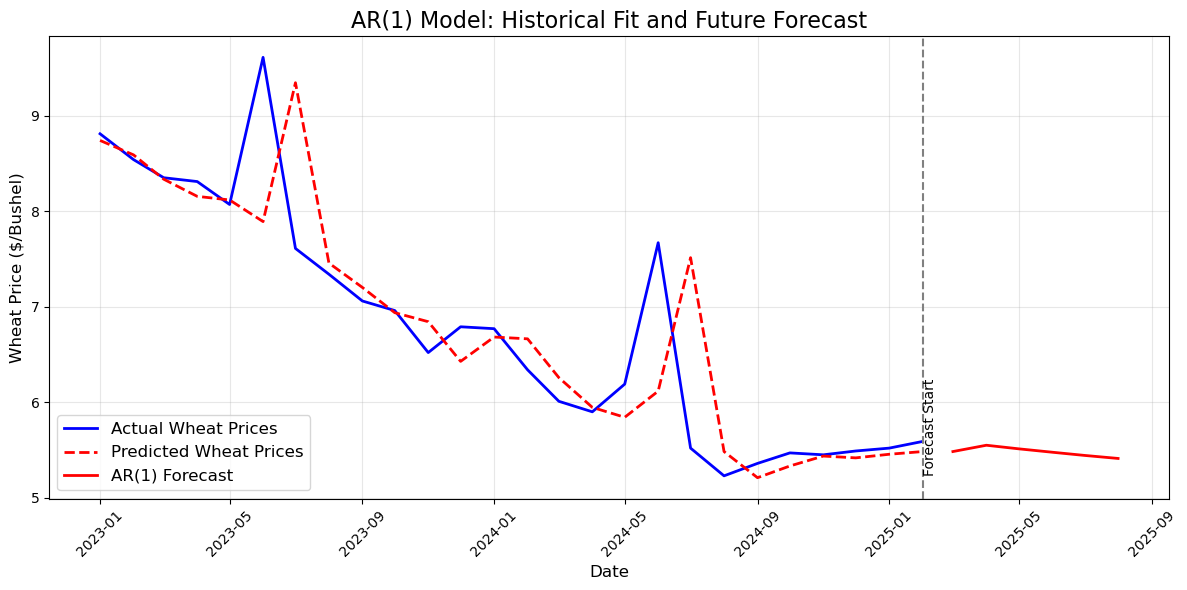

In [36]:
#Plot AR(1) Predictions and Forecasts
plt.figure(figsize=(12, 6))

#plot true time series
plt.plot(last_2_years['date'], last_2_years['wheat_price'], 'b-', 
         linewidth=2, label='Actual Wheat Prices')

#plot predictions
plt.plot(last_2_years['date'], last_2_years['ar1_predictions'], 'r--', 
         linewidth=2, label='Predicted Wheat Prices')

#add line for forecast date
plt.axvline(x=last_date, linestyle='--', color='gray')
plt.text(last_date, min(last_2_years['wheat_price']), 
         'Forecast Start', rotation=90, verticalalignment='bottom')

#plot forecast
plt.plot(forecast_df_plt['date'], forecast_df_plt['AR1'], 
         'r-', linewidth=2, 
         label='AR(1) Forecast')

#label and save
plt.title('AR(1) Model: Historical Fit and Future Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Wheat Price ($/Bushel)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Visualizations/AR_1_Prediction.png')
plt.show()

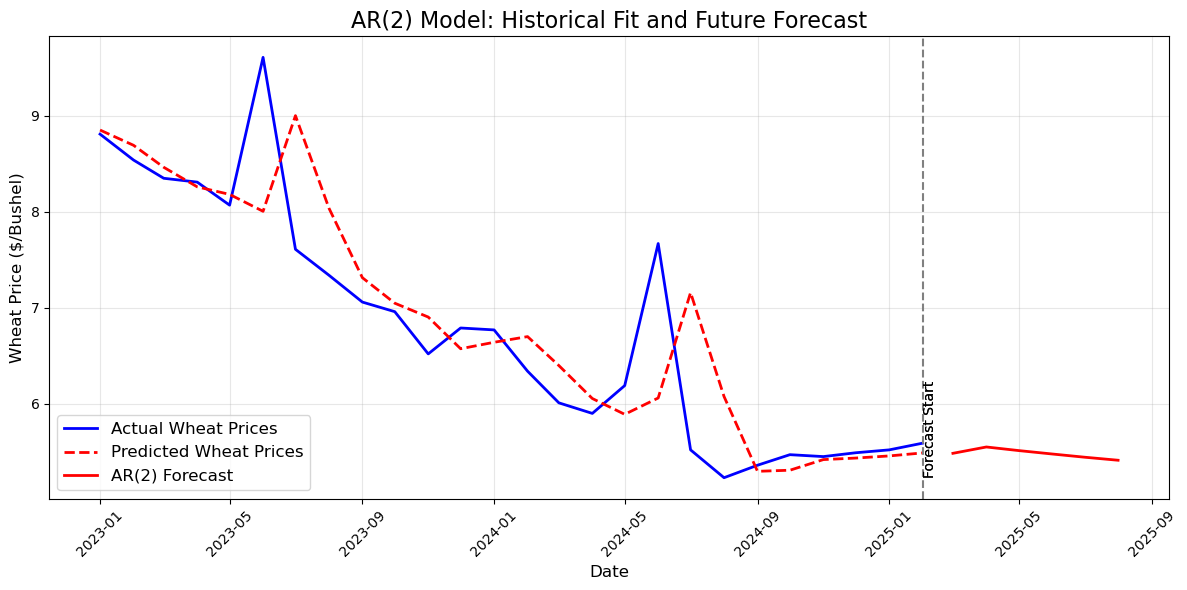

In [37]:
#Plot AR(2) Predictions and Forecasts 
plt.figure(figsize=(12, 6))

#plot true time series
plt.plot(last_2_years['date'], last_2_years['wheat_price'], 'b-', 
         linewidth=2, label='Actual Wheat Prices')

#plot predictions
plt.plot(last_2_years['date'], last_2_years['ar2_predictions'], 'r--', 
         linewidth=2, label='Predicted Wheat Prices')

#add line for forecast date
plt.text(last_date, min(last_2_years['wheat_price']), 
         'Forecast Start', rotation=90, verticalalignment='bottom')
plt.axvline(x=last_date, linestyle='--', color='gray')
plt.text(last_date, min(last_2_years['wheat_price']), 
         'Forecast Start', rotation=90, verticalalignment='bottom')

#plot forecast
plt.plot(forecast_df_plt['date'], forecast_df_plt['AR2'], 
         'r-', linewidth=2, 
         label='AR(2) Forecast')

#label and save
plt.title('AR(2) Model: Historical Fit and Future Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Wheat Price ($/Bushel)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Visualizations/AR_1_Prediction.png')
plt.show()

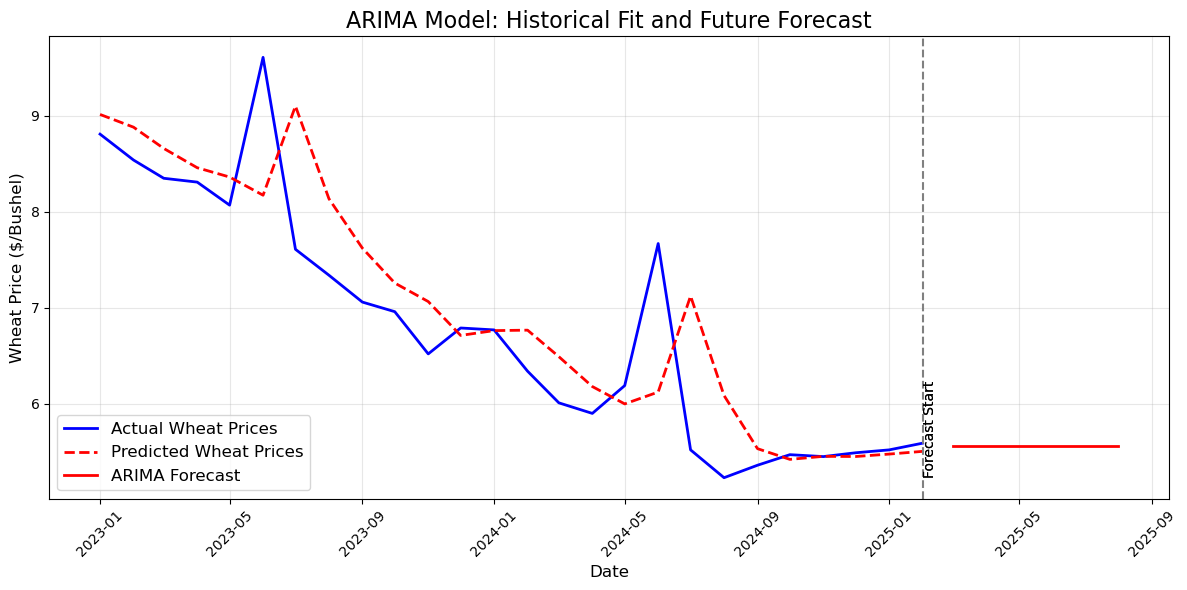

In [38]:
#Plot ARIMA Predictions and Forecasts
plt.figure(figsize=(12, 6))

#plot true time series
plt.plot(last_2_years['date'], last_2_years['wheat_price'], 'b-', 
         linewidth=2, label='Actual Wheat Prices')

#plot predictions
plt.plot(last_2_years['date'], last_2_years['arima_predictions'], 'r--', 
         linewidth=2, label='Predicted Wheat Prices')

#add line for forecast date
plt.text(last_date, min(last_2_years['wheat_price']), 
         'Forecast Start', rotation=90, verticalalignment='bottom')
plt.axvline(x=last_date, linestyle='--', color='gray')
plt.text(last_date, min(last_2_years['wheat_price']), 
         'Forecast Start', rotation=90, verticalalignment='bottom')

#plot forecast
plt.plot(forecast_df_plt['date'], forecast_df_plt['ARIMA'], 
         'r-', linewidth=2, 
         label='ARIMA Forecast')

#label and save
plt.title('ARIMA Model: Historical Fit and Future Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Wheat Price ($/Bushel)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Visualizations/AR_1_Prediction.png')
plt.show()

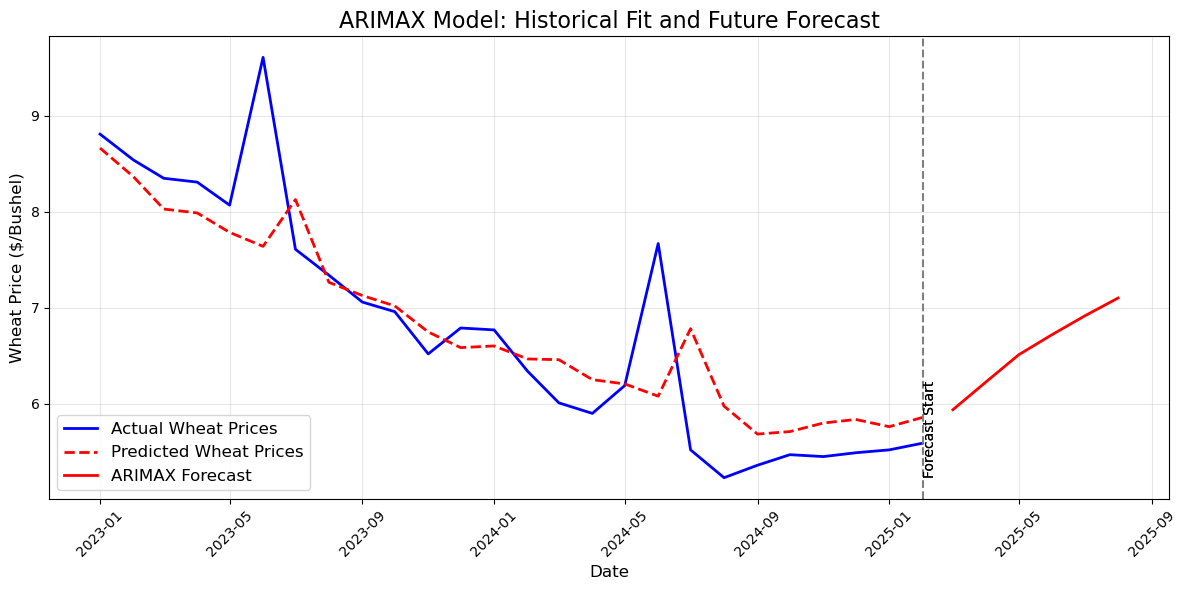

In [39]:
#Plot ARIMAX Predictions and Forecasts
plt.figure(figsize=(12, 6))

#plot true time series
plt.plot(last_2_years['date'], last_2_years['wheat_price'], 'b-', 
         linewidth=2, label='Actual Wheat Prices')

#plot predictions
plt.plot(last_2_years['date'], last_2_years['arimax_predictions'], 'r--', 
         linewidth=2, label='Predicted Wheat Prices')

#add line for forecast date
plt.text(last_date, min(last_2_years['wheat_price']), 
         'Forecast Start', rotation=90, verticalalignment='bottom')
plt.axvline(x=last_date, linestyle='--', color='gray')
plt.text(last_date, min(last_2_years['wheat_price']), 
         'Forecast Start', rotation=90, verticalalignment='bottom')

#plot forecast
plt.plot(forecast_df_plt['date'], forecast_df_plt['ARIMAX'], 
         'r-', linewidth=2, 
         label='ARIMAX Forecast')

#label and save
plt.title('ARIMAX Model: Historical Fit and Future Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Wheat Price ($/Bushel)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Visualizations/AR_1_Prediction.png')
plt.show()

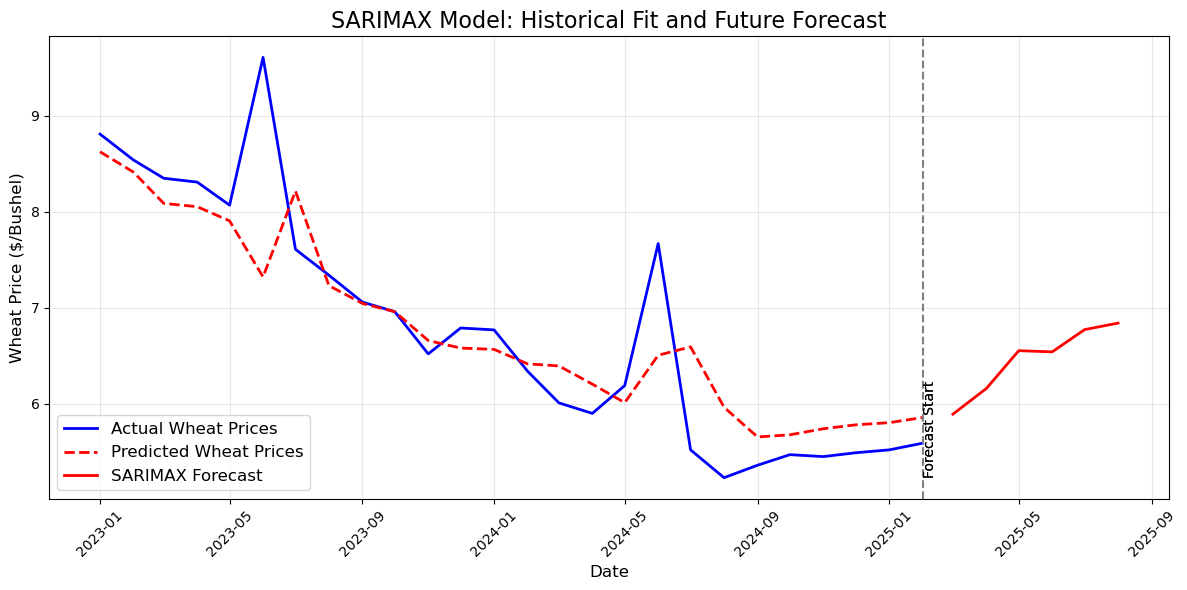

In [40]:
#Plot SARIMAX Predictions and Forecasts
plt.figure(figsize=(12, 6))

#plot true time series
plt.plot(last_2_years['date'], last_2_years['wheat_price'], 'b-', 
         linewidth=2, label='Actual Wheat Prices')

#plot predictions
plt.plot(last_2_years['date'], last_2_years['sarimax_predictions'], 'r--', 
         linewidth=2, label='Predicted Wheat Prices')

#add line for forecast date
plt.text(last_date, min(last_2_years['wheat_price']), 
         'Forecast Start', rotation=90, verticalalignment='bottom')
plt.axvline(x=last_date, linestyle='--', color='gray')
plt.text(last_date, min(last_2_years['wheat_price']), 
         'Forecast Start', rotation=90, verticalalignment='bottom')

#plot forecast
plt.plot(forecast_df_plt['date'], forecast_df_plt['SARIMAX'], 
         'r-', linewidth=2, 
         label='SARIMAX Forecast')

#label and save
plt.title('SARIMAX Model: Historical Fit and Future Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Wheat Price ($/Bushel)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Visualizations/AR_1_Prediction.png')
plt.show()

## 2 Machine Learning Models

In [226]:
#split data into 80% train and 20% test with date (sarimax) and without (rf)
X = df.drop(columns=['wheat_price','date']).reset_index(drop=True)
y = df['wheat_price'].reset_index(drop=True)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

### 2.1 Basic Decision Tree Regressor

In [229]:
#hyperparameter tuning for best decision tree model
params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#run grid search cross-validation for tuning
dt_model = DecisionTreeRegressor(random_state=42) #initialize
dt_gridsearch = GridSearchCV(dt_model, params,cv=5) #start gridsearch
dt_gridsearch.fit(X_train, y_train) #fit model
best_params = dt_gridsearch.best_params_ #find best parameters
print(f"Best Parameters: {best_params}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [231]:
#run model using best hyperparameters
best_dt = DecisionTreeRegressor(**best_params,random_state=42) #initialize
best_dt.fit(X_train, y_train) #fit model
dt_pred = best_dt.predict(X_test) #predict

In [233]:
#calculate performance measures
dt_mse = mean_squared_error(y_test, dt_pred)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(y_test, dt_pred)
dt_r2 = r2_score(y_test, dt_pred)

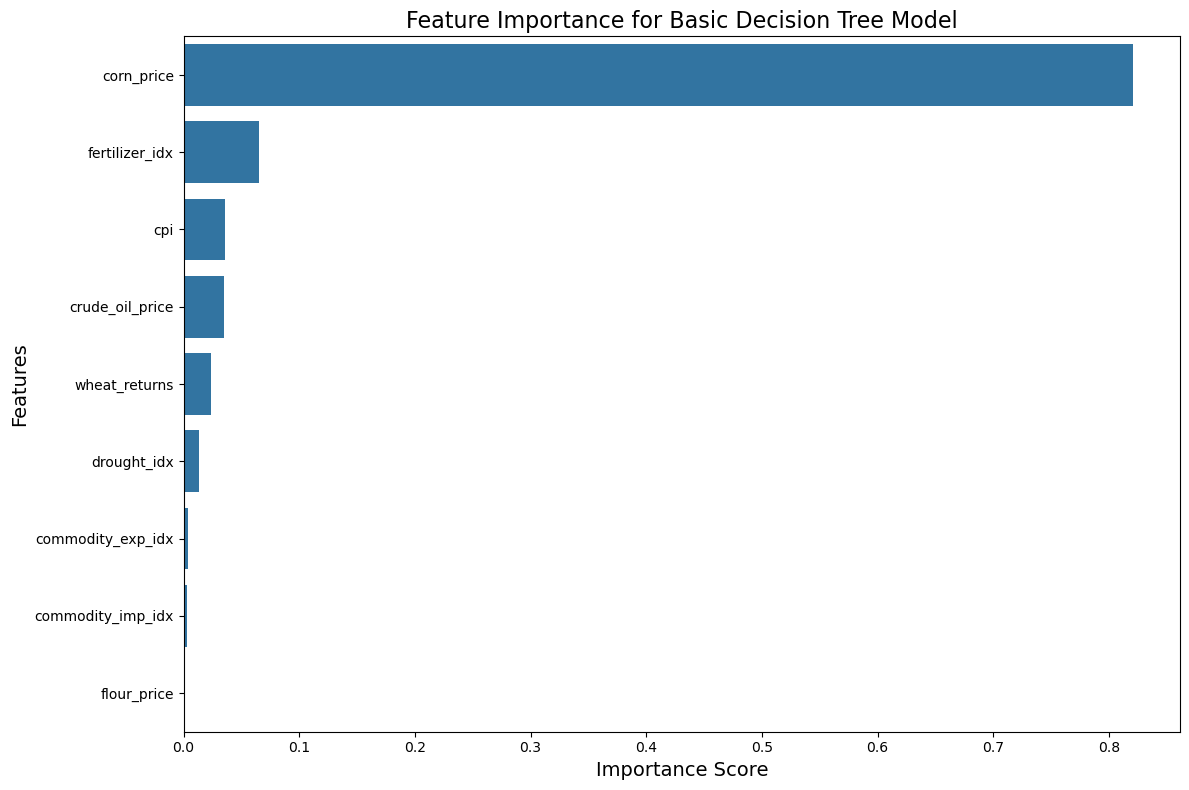

In [241]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_dt.feature_importances_
}).sort_values('Importance', ascending=False)

#plot above
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Basic Decision Tree Model', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.savefig('../Visualizations/DT_Feature_Importance.png')
plt.show()

### 2.2 Ensemble Learning Models

### 2.2.1 Random Forest Regressor Model

In [243]:
#hyperparameter tune for best rf model
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
#run grid search cross-validation for tuning
rf_model = RandomForestRegressor(random_state=42) #initialize
rf_gridsearch = GridSearchCV(rf_model, rf_params,cv=5) #start gridsearch
rf_gridsearch.fit(X_train, y_train) #fit model
best_rf_params = rf_gridsearch.best_params_ #find best parameters
print(f"Best Random Forest Parameters: {best_rf_params}")

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [245]:
#run random forest model
best_rf = RandomForestRegressor(**best_params, random_state=42) #initialize
best_rf.fit(X_train, y_train) #fit
rf_pred = best_rf.predict(X_test) #predict

In [247]:
#calculate performance measures
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

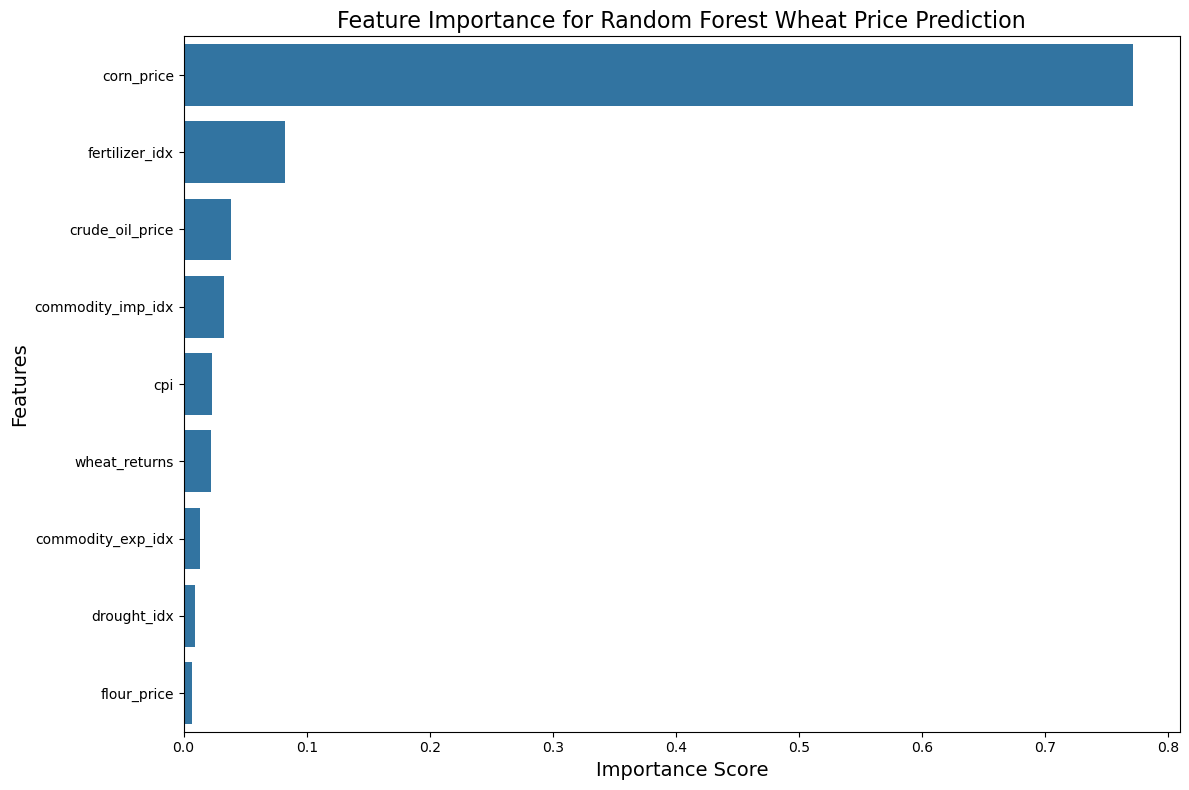

In [249]:
#check feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

#plot above
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Random Forest Wheat Price Prediction', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.savefig('../Visualizations/RF_Feature_Importance.png')
plt.show()

### 2.2.2 Gradient Boosting Regressor Model

In [251]:
#hyperparameter tuning for best xgboost model
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 0.9, 1.0]
}
gb_model = GradientBoostingRegressor(random_state=42) #initialize
gb_gridsearch = GridSearchCV(gb_model, gb_params,cv=5)
gb_gridsearch.fit(X_train, y_train) #fit model
best_gb_params = gb_gridsearch.best_params_ #find best parameters
print(f"Best Random Forest Parameters: {best_gb_params}")

Best Random Forest Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}


In [255]:
#run model using best hyperparameters
best_gb = GradientBoostingRegressor(**best_gb_params,random_state=42) #initialize
best_gb.fit(X_train, y_train) #fit
gb_pred = best_gb.predict(X_test)

In [257]:
#calculate performance measures
gb_mse = mean_squared_error(y_test, gb_pred)
gb_rmse = np.sqrt(rf_mse)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

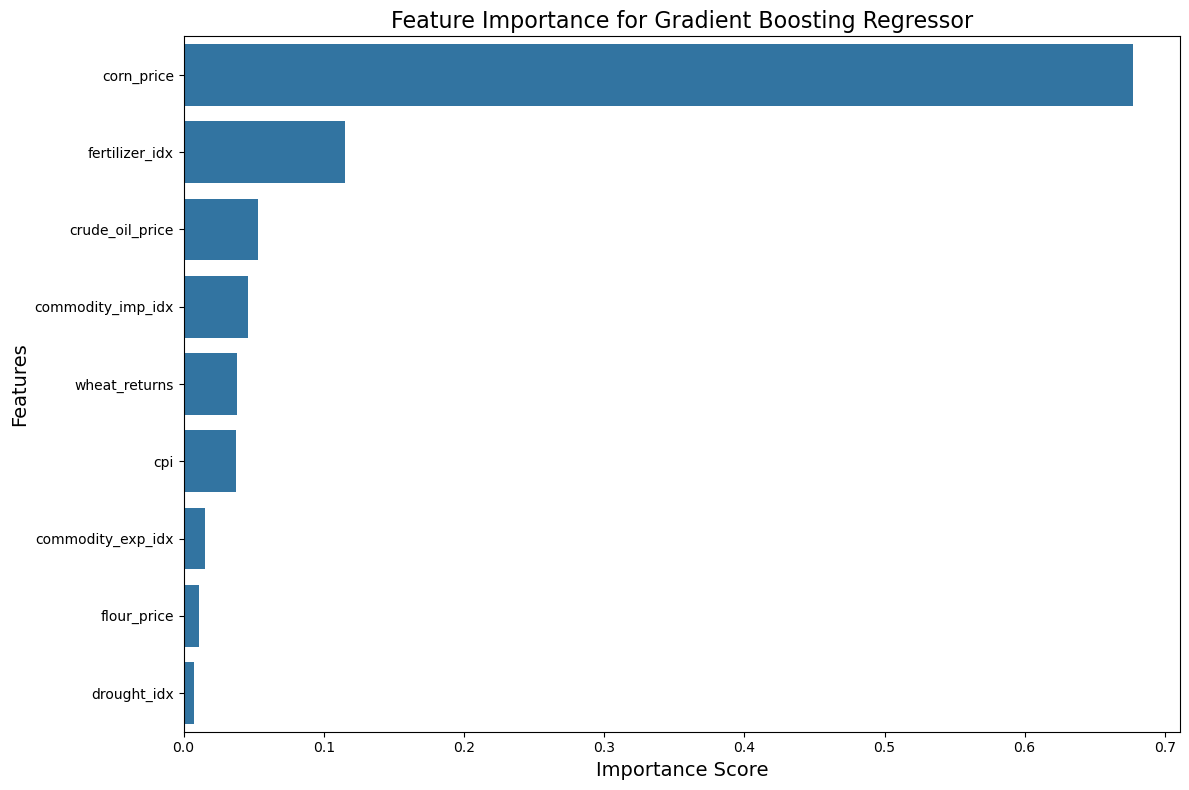

In [259]:
#check feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_gb.feature_importances_
}).sort_values('Importance', ascending=False)

#plot above
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Gradient Boosting Regressor', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.savefig('../Visualizations/GB_Feature_Importance.png')
plt.show()

### 2.3 Tree Model Comparison

In [261]:
dt_comparison = {
    'Model': ['Decision Tree (Basic)', 'Random Forest', 'Gradient Boosting'],
    'MSE': [dt_mse, rf_mse, gb_mse],
    'RMSE': [np.sqrt(dt_mse), np.sqrt(rf_mse), np.sqrt(gb_mse)],
    'MAE': [dt_mae, rf_mae, gb_mae],
    'R²': [dt_r2, rf_r2, gb_r2],
}
dt_comparison = pd.DataFrame(dt_comparison)
dt_comparison

,Model,MSE,RMSE,MAE,R²
0,Decision Tree (Basic),0.385435,0.620834,0.404683,0.870041
1,Random Forest,0.351474,0.592852,0.361507,0.881492
2,Gradient Boosting,0.286206,0.534982,0.325100,0.903499


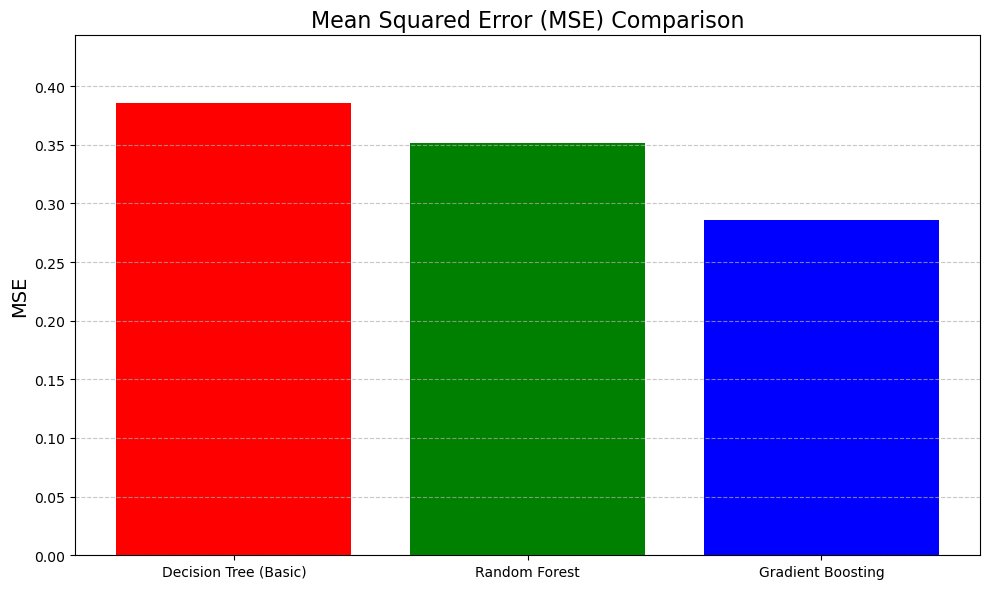

In [267]:
#plot MSE comparisons
plt.figure(figsize=(10, 6))

# Create bar plot
bars = plt.bar(dt_comparison['Model'], dt_comparison['MSE'], color = ['r','g','b'], linewidth = 1)

# Add title and labels
plt.title('Mean Squared Error (MSE) Comparison', fontsize=16)
plt.ylabel('MSE', fontsize=14)
plt.ylim(0, max(dt_comparison['MSE']) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.savefig('../Visualizations/DecisionT_MSE_Comparison.png')
plt.show()

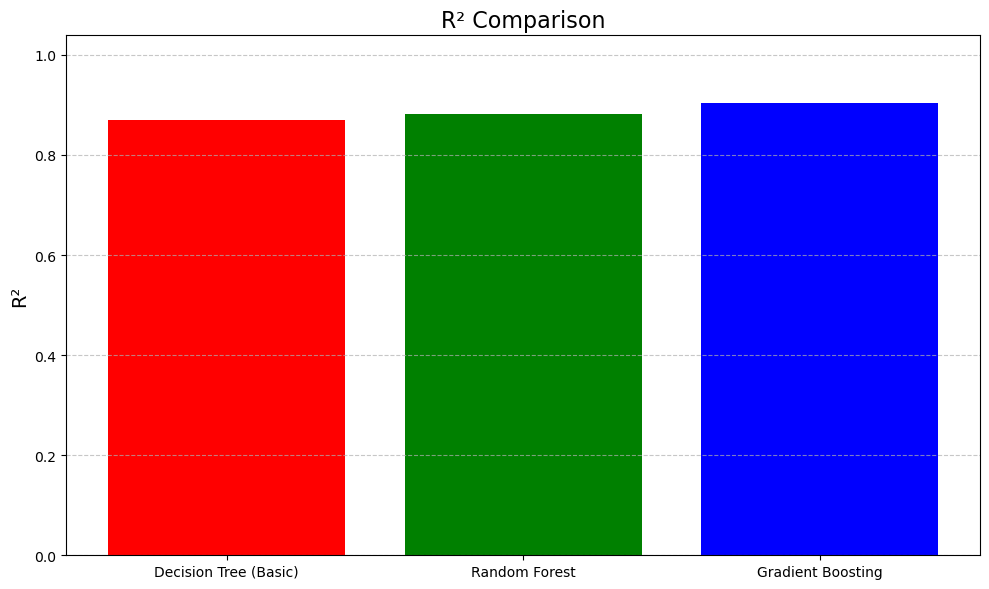

In [269]:
#plot R squared comparisons
plt.figure(figsize=(10, 6))

# Create bar plot
bars = plt.bar(dt_comparison['Model'], dt_comparison['R²'], color = ['r','g','b'], linewidth = 1)

# Add title and labels
plt.title('R² Comparison', fontsize=16)
plt.ylabel('R²', fontsize=14)
plt.ylim(0, max(dt_comparison['R²']) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.savefig('../Visualizations/DecisionT_Rsq_Comparison.png')
plt.show()

In [132]:
#run sarimax on train/test set for predictions
sarimax_ml = SARIMAX(
    y_train,
    exog=X_train,
    order=(2,1,1),
    seasonal_order=(1,0,1,12)
)
sarimax_ml_results = sarimax_ml.fit(disp=False)

sarimax_test_pred = sarimax_ml_results.predict(X_test) #predict for test set

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [135]:
sarimax_mse = mean_squared_error(test_data['wheat_price'], sarimax_test_pred)
sarimax_rmse = np.sqrt(sarimax_mse)
sarimax_mae = mean_absolute_error(test_data['wheat_price'], sarimax_test_pred)
sarimax_r2 = r2_score(test_data['wheat_price'], sarimax_test_pred)

ValueError: Found input variables with inconsistent numbers of samples: [84, 336]

In [ ]:
model_comparison = pd.DataFrame({
    'Model': ['SARIMAX', 'Random Forest'],
    'MSE': [sarimax_mse, rf_mse],
    'RMSE': [sarimax_rmse, rf_rmse],
    'MAE': [sarimax_mae, rf_mae],
    'R²': [sarimax_r2, rf_r2]
})
model_comparison

## 2.2 Model Evaluation

#### 2.2.1 Visualizations